In [1]:
!git clone https://github.com/olegolas912/ConDiff.git
# !pip install -r requirements.txt
!pip install --upgrade "jax[cuda12]==0.6.0" jax-cuda12-plugin==0.6.0
!pip install equinox
!pip install parafields
%cd /kaggle/working/ConDiff

Cloning into 'ConDiff'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 132 (delta 40), reused 39 (delta 20), pack-reused 72 (from 1)
Receiving objects: 100% (132/132), 73.45 MiB | 46.66 MiB/s, done.
Resolving deltas: 100% (65/65), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 91.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 MB 13.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 19.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 87.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 43.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: jax-cuda12-p

In [2]:
import jax.numpy as jnp
import os
import jax

# jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platforms', 'cpu')
# os.environ["CUDA_VISIBLE_DEVICES"] = ''
# os.environ["JAX_PLATFORMS"] = 'cpu'

from condiff import multiple_poisson, multiple_diffusion
path = "/kaggle/working/ConDiff"
try:
    os.mkdir(os.path.join(path, 'ConDiff'))
except:
    pass
save_dir = os.path.join(path, 'ConDiff')
# Parameters for Poisson and diffusion euqtions
N_train = 1000
N_test = 200
grid_ls = [64]

# Parameters only for diffusion equation
cov_model_ls = ['cubic', 'exponential', 'gaussian']
boundaries_ls = [                                          # Contrast boundaries to control complexity
    [[5, 15], [50, 250], [600, 1000], [80000, 100000]],
    [[5, 15], [50, 250], [600, 1000], [80000, 100000]]
]
var_ls = [0.1, 0.4, 1.0, 2.0]
multiple_poisson(save_dir, N_train, N_test, grid_ls, seed_rng=42)

In [3]:
!ls
%cd /kaggle/working/ConDiff

poisson_grid64_test.h5	poisson_grid64_train.h5
/kaggle/working/ConDiff


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# import optax
# import equinox as eqx
import numpy as np
# import jax.numpy as jnp
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from IPython import display
from functools import partial
# from jax.lax import scan, dot_general
from load_ConDiff import load_ConDiff
# from architectures import UNet
# from jax import config, random, grad, vmap, jit
# from jax.tree_util import tree_map, tree_flatten
import torch, time, pandas as pd
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from architectures.IAFNO_pt import get_IAFNO_pt
import os
import math
from itertools import product
from copy import deepcopy
import math
from torch.optim.lr_scheduler import LambdaLR

CHECKPOINT_PATH = "iafno_poisson64.pth"

In [6]:
def relative_error(pred, targ):
    return ((pred - targ).view(pred.size(0), -1).norm(dim=1) /
            targ.view(targ.size(0), -1).norm(dim=1))

def save_checkpoint(model, optimizer, epoch, history, path=CHECKPOINT_PATH):
    torch.save({
        "epoch":   epoch,
        "model":   model.state_dict(),
        "optim":   optimizer.state_dict(),
        "history": history,
    }, path)

def load_checkpoint(model, optimizer=None, path=CHECKPOINT_PATH, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model"])
    if optimizer is not None:
        optimizer.load_state_dict(ckpt["optim"])
    return ckpt["epoch"], ckpt["history"]

def huber_relative_error(pred, targ, delta=0.01):
    """
    Huber-loss по пикселям, затем нормируем на ‖target‖, как в relative_error.
    delta — порог между L1 и L2; 0.01 работает для карт в диапазоне ~[0,1].
    """
    diff = pred - targ
    abs_diff = diff.abs()
    quad = torch.clamp(abs_diff, max=delta)
    lin  = abs_diff - quad
    huber = 0.5 * quad.pow(2) / delta + lin           # SmoothL1 вручную
    per_sample = huber.view(huber.size(0), -1).sum(dim=1)
    denom = targ.view(targ.size(0), -1).norm(dim=1) + 1e-8
    return per_sample / denom


In [7]:
from tqdm.auto import tqdm
import math, torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

# --- Physics‐informed loss класс ---
class PhysicsInformedLoss(nn.Module):
    def __init__(self, dx=1.0, dt=1.0, lambda_phys=1e-3):
        super().__init__()
        self.dx, self.dt, self.lambda_phys = dx, dt, lambda_phys
        self.mse = nn.MSELoss()

    def forward(self, u_pred, u_true, coeff):
        # простой пример: residual = div(a·grad(u)) + f
        u_x = torch.gradient(u_pred, dim=2)[0] / self.dx
        u_xx = torch.gradient(u_x, dim=2)[0] / self.dx
        r = coeff * u_xx  # << тут можно добавить +f, boundary и т.д.
        data_loss = self.mse(u_pred, u_true)
        phys_loss = torch.mean(r**2)
        return data_loss + self.lambda_phys * phys_loss    # <-- объединённая потеря

def train_model_pt(model_data, features, targets, spec, device):
    """обучает модель и возвращает (model, hist_train, hist_test)"""
    model = model_data["model"].to(device)
    feats_tr, feats_ts = [t.to(device) for t in features]
    targs_tr, targs_ts = [t.to(device) for t in targets]

    # ---- оптимизатор ----
    opt = AdamW(model.parameters(),
                lr=spec["learning_rate"],
                weight_decay=spec["weight_decay"])

    # ---- One-cycle LR policy ----
    total_steps = spec["N_epochs"] * (len(feats_tr) // spec["batch_size"])
    scheduler = OneCycleLR(opt,
                           max_lr=spec["learning_rate"],
                           total_steps=total_steps)  # <-- One-cycle

    # ---- EMA модели ----
    ema_model = deepcopy(model)
    ema_decay = 0.999                                 # <-- EMA decay

    # ---- Curriculum learning по контрасту ----
    global_max = torch.amax(feats_tr, dim=(1,2,3))    # <-- заменили .max(dim=[...])
    global_min = torch.amin(feats_tr, dim=(1,2,3))    # <-- заменили .min(dim=[...])
    contrasts = (global_max - global_min).cpu().numpy()  
    
    sorted_idx = np.argsort(contrasts)               # <-- индексы по возрастанию контраста

    phys_loss_fn = PhysicsInformedLoss(dx=1.0, dt=1.0, lambda_phys=1e-3)

    hist_train, hist_test = [], []                    # <-- инициализация истории

    for epoch in range(1, spec["N_epochs"] + 1):
        model.train()
        # curriculum: растущая доля «лёгких» примеров
        pct = epoch / spec["N_epochs"]
        N_curr = max(1, int(len(sorted_idx) * pct))
        curr_idx = sorted_idx[:N_curr]
        perm = np.random.permutation(curr_idx)
        idx = torch.tensor(perm, device=device)

        # --- шаги обучения ---
        for i in range(0, len(idx), spec["batch_size"]):
            b = idx[i : i + spec["batch_size"]]
            x = feats_tr[b]
            y = targs_tr[b]

            # Coefficient-field augmentation
            if torch.rand(1) < 0.5:
                x = torch.flip(x, dims=[-1])
            if torch.rand(1) < 0.5:
                x = x.transpose(-2, -1)

            pred = model(x)
            loss = phys_loss_fn(pred, y, coeff=x[:,0:1,...])

            opt.zero_grad()
            loss.backward()
            opt.step()
            scheduler.step()                        # <-- One-cycle update

            # EMA-update
            with torch.no_grad():
                for ema_p, p in zip(ema_model.parameters(), model.parameters()):
                    ema_p.mul_(ema_decay).add_(p, alpha=1 - ema_decay)

        # --- валидация на EMA-модели ---
        ema_model.eval()
        with torch.no_grad():
            pred_ts   = ema_model(feats_ts)
            test_loss = phys_loss_fn(pred_ts, targs_ts, coeff=feats_ts[:,0:1,...])

        hist_train.append(loss.item())              # <-- сохраняем train loss
        hist_test.append(test_loss.item())          # <-- сохраняем test loss
        print(f"Epoch {epoch:02d} ▶ train={loss:.4e}  test={test_loss:.4e}")

    return model, hist_train, hist_test        # <-- возвращаем как просили


In [8]:
def get_results(grid, type_of_pde="poisson", direction_to_save="ConDiff"):
    import load_ConDiff
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. датасет
    (feat_tr, targ_tr), (feat_ts, targ_ts) = load_ConDiff.get_datasets(
        direction_to_save, type_of_pde, grid
    )
    feat_tr = torch.tensor(feat_tr, dtype=torch.float32, device=device)
    targ_tr = torch.tensor(targ_tr, dtype=torch.float32, device=device)
    feat_ts = torch.tensor(feat_ts, dtype=torch.float32, device=device)
    targ_ts = torch.tensor(targ_ts, dtype=torch.float32, device=device)

    xs = torch.linspace(0, 1, grid, device=device)
    ys = torch.linspace(0, 1, grid, device=device)
    X, Y = torch.meshgrid(xs, ys, indexing="xy")      # shape (grid,grid)
    coords = torch.stack([X, Y], dim=0)               # (2, grid, grid)
    coords = coords.unsqueeze(0).repeat(feat_tr.size(0), 1, 1, 1)  
    # теперь feat_tr (B,1,grid,grid) → (B,3,grid,grid)
    feat_tr = torch.cat([feat_tr, coords], dim=1)
    feat_ts = torch.cat([feat_ts, coords[:feat_ts.size(0)]], dim=1)

    # ——— 2) Z-score нормировка ———
    f_mean, f_std = feat_tr.mean(), feat_tr.std()
    feat_tr = (feat_tr - f_mean) / f_std
    feat_ts = (feat_ts - f_mean) / f_std
    
    u_mean, u_std = targ_tr.mean(), targ_tr.std()
    targ_tr = (targ_tr - u_mean) / u_std
    targ_ts = (targ_ts - u_mean) / u_std

    
    # 2. модель + оптимизация
    model_data, spec = get_IAFNO_pt(grid, device)
    model, h_train, h_test = train_model_pt(
        model_data,
        [feat_tr, feat_ts],
        [targ_tr, targ_ts],
        spec,
        device,
        use_huber=True
    )

    # 3. итоговая метрика
    model.eval()
    with torch.no_grad():
        pred = model(feat_ts)
        err  = relative_error(pred, targ_ts)
    data = {
        "history_train": h_train,
        "history_test" : h_test,
        "test_error_mean": err.mean().item(),
        "test_error_std" : err.std().item()
    }
    return data, model, model_data, feat_ts, targ_ts


In [9]:
def plot_results(model, history, features_test, targets_test):
    """
    model         : обученная IAFNO (PyTorch)
    history       : dict  {'history_train': [...], 'history_test': [...]}
    features_test : torch.Tensor (N,1,H,W)  – rhs
    targets_test  : torch.Tensor (N,1,H,W)  – solution
    """
    model.eval()
    with torch.no_grad():
        pred = model(features_test).cpu().numpy()[:, 0]   # (N,H,W)

    targ = targets_test.cpu().numpy()[:, 0]

    display.clear_output(wait=True)
    plt.rcParams["font.family"] = "serif"

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    # кривая потерь
    ax[0].set_title("Loss")
    ax[0].set_yscale("log")
    ax[0].plot(history["history_train"], "-",  color="red",   label="train")
    ax[0].plot(history["history_test"],  "-.", color="green", label="test")
    ax[0].legend();  ax[0].grid(ls="-.")
    ax[0].spines[["top", "right"]].set_visible(False)

    ax[1].contourf(pred[0]);  ax[1].set_title("Prediction")
    ax[2].contourf(targ[0]);  ax[2].set_title("Target")

    plt.tight_layout();  plt.show()


In [10]:
%cd /kaggle/working/ConDiff

/kaggle/working/ConDiff


In [11]:
import os, shutil, glob, pathlib

ROOT = "/kaggle/working/ConDiff"                 # корень репо

# -------------------------------------------------
# 1. перенос poisson_grid* в .../ConDiff/df/ConDiff
# -------------------------------------------------
extra_dirs = ["poisson_grid64", "poisson_grid128"]
for name in extra_dirs:
    src = os.path.join(ROOT,"ConDiff", name)
    dst = os.path.join(ROOT, "ConDiff", "df","ConDiff", name)
    if os.path.exists(src) and not os.path.exists(dst):
        print(f"→ move {src}  →  {dst}")
        shutil.move(src, dst)
    else:
        print(f"✓ {name} уже на месте или не найден")

print("\n📂  Структура каталогов поправлена.")


→ move /kaggle/working/ConDiff/ConDiff/poisson_grid64  →  /kaggle/working/ConDiff/ConDiff/df/ConDiff/poisson_grid64
✓ poisson_grid128 уже на месте или не найден

📂  Структура каталогов поправлена.


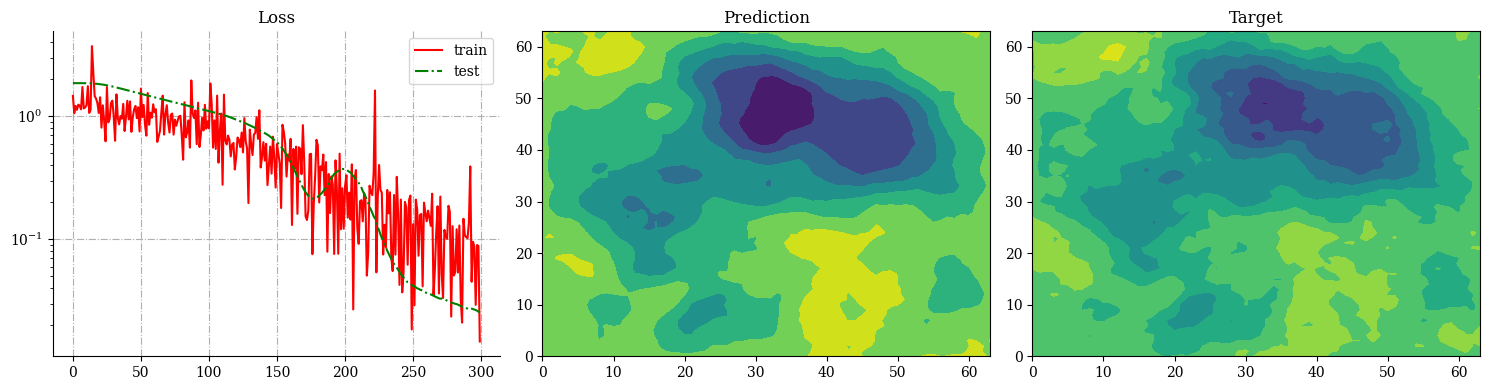

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grid   = 64
CHECKPOINT_PATH = "iafno_poisson64.pth"

model_data, spec = get_IAFNO_pt(grid, device)
model = model_data["model"]

# ---------- датасет -------------------------------------------------------
save_dir = "/kaggle/working/ConDiff/ConDiff"
(rhs_tr, x_tr), (rhs_ts, x_ts) = load_ConDiff(save_dir,"poisson",grid)

# 1) Load and reshape your data as single-channel RHS:
rhs_tr = rhs_tr.reshape(-1, 1, grid, grid)
rhs_ts = rhs_ts.reshape(-1, 1, grid, grid)

feat_tr = torch.tensor(rhs_tr, dtype=torch.float32, device=device)
feat_ts = torch.tensor(rhs_ts, dtype=torch.float32, device=device)

# 2) Create the (x,y) coordinate maps once:
xs = torch.linspace(0, 1, grid, device=device)
ys = torch.linspace(0, 1, grid, device=device)
X, Y = torch.meshgrid(xs, ys, indexing='xy')       # each is (H,W)
coords = torch.stack([X, Y], dim=0)                 # (2,H,W)
coords = coords.unsqueeze(0)                        # (1,2,H,W)
coords_tr = coords.repeat(feat_tr.size(0), 1, 1, 1) # (N_tr,2,H,W)
coords_ts = coords.repeat(feat_ts.size(0), 1, 1, 1) # (N_ts,2,H,W)

# 3) Concatenate to get (N,3,H,W):
feat_tr = torch.cat([feat_tr, coords_tr], dim=1)
feat_ts = torch.cat([feat_ts, coords_ts], dim=1)

# 4) Now compute Z-score on all three channels and normalise:
f_mean, f_std = feat_tr.mean(), feat_tr.std()
feat_tr = (feat_tr - f_mean) / f_std
feat_ts = (feat_ts - f_mean) / f_std

# 5) Targets as before:
targ_tr = torch.tensor(x_tr.reshape(-1,1,grid,grid), dtype=torch.float32, device=device)
targ_ts = torch.tensor(x_ts.reshape(-1,1,grid,grid), dtype=torch.float32, device=device)
u_mean, u_std = targ_tr.mean(), targ_tr.std()
targ_tr = (targ_tr - u_mean) / u_std
targ_ts = (targ_ts - u_mean) / u_std

# 6) Train or load checkpoint exactly as in your script
if os.path.isfile(CHECKPOINT_PATH):
    _, history = load_checkpoint(model, path=CHECKPOINT_PATH, map_location=device)
    print("Checkpoint found — skipping training.")
else:
    model, h_tr, h_ts = train_model_pt(
        model_data,
        [feat_tr, feat_ts],
        [targ_tr, targ_ts],
        spec,
        device
    )
    history = {"history_train": h_tr, "history_test": h_ts}
    print("Training complete.")

# ---------- оценка и график ----------------------------------------------
model.eval()
with torch.no_grad():
    pred = model(feat_ts)
    err  = relative_error(pred, targ_ts)

print(f"IAFNO  test error: {err.mean():.3f} ± {err.std():.3f}")

plot_results(model, history, feat_ts, targ_ts)


In [13]:
print(f"IAFNO  test error: {err.mean():.3f} ± {err.std():.3f}")

IAFNO  test error: 0.170 ± 0.054


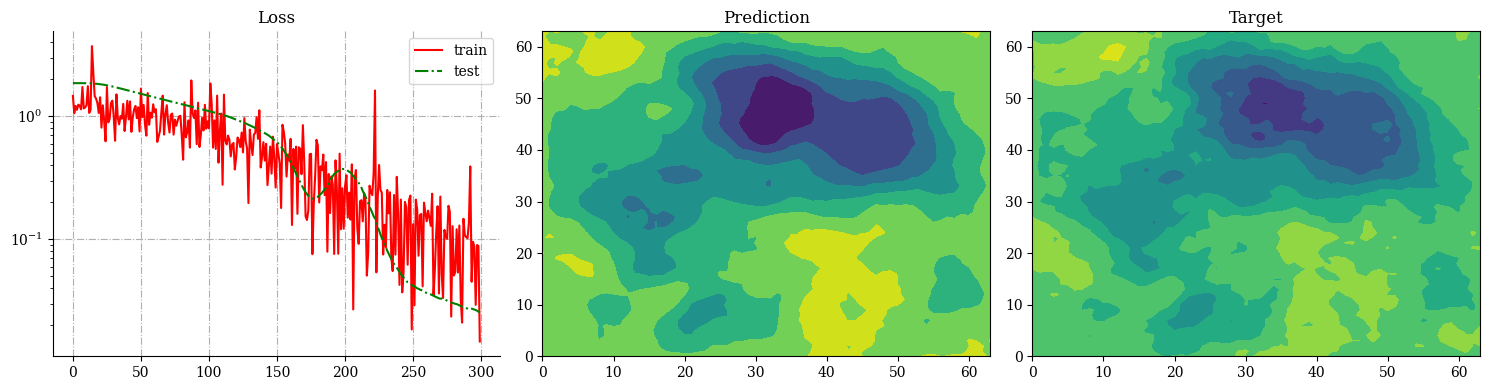

In [14]:
plot_results(model, history, feat_ts, targ_ts)

In [15]:
model_size = data['model_size']
train_error_mean = jnp.round(data['train_error_mean'], 3)
test_error_mean = jnp.round(data['test_error_mean'], 3)
train_error_std = jnp.round(data['train_error_std'], 3)
test_error_std = jnp.round(data['test_error_std'], 3)

print(f'Model size: {model_size}')
print(f"Train relative error: {train_error_mean} ± {train_error_std}, \nTest relative error: {test_error_mean} ± {test_error_std}")

NameError: name 'data' is not defined